# House Prices Prediction Model Training and Evaluation Notebook

# Part 1 - DEFINE
***

### ---- 1 Define the problem ----

In this notebook, using the Kaggle [dataset](https://www.kaggle.com/c/house-prices-advanced-regression-techniques/data?select=train.csv), first, I'll establish simple baseline model, and then I'll develop a few predictive models and compare the performance against the baseline 

### Objective: 
- To understand what factors contribute most to house prices.

- To create a model that predicts the price of a house with a given several features. 

- To create or improve predictive accuracy of the model compared to baseline model

The implementation of this model will allow housing agencies (e.g., CMHC), real-estate companies, banks, municipial governments and home buyers to make informed decisions.

### Check versions of the Python and some key packages to ensure most recent version is used

In [248]:
%load_ext watermark
%watermark -a 'Vusal Babashov' -u -d -v -p numpy,mlxtend,matplotlib,sklearn

The watermark extension is already loaded. To reload it, use:
  %reload_ext watermark
Author: Vusal Babashov

Last updated: 2021-02-22

Python implementation: CPython
Python version       : 3.8.2
IPython version      : 7.20.0

numpy     : 1.19.2
mlxtend   : 0.18.0
matplotlib: 3.3.2
sklearn   : 0.23.2



### Import Libraries

In [249]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

from sklearn.impute import SimpleImputer


#your info here
__author__ = "Vusal Babashov"
__email__ = "vbabashov@gmail.com"
__website__ = 'https://vbabashov.github.io'

### Load the Data

In [250]:
#load the data into a Pandas dataframe
file_path = "/Users/vusalbabashov/Desktop/house-prices/data/"
df_train = pd.read_csv(file_path + "train.csv")
df_test_feature = pd.read_csv(file_path + "test.csv")
df_test_target = pd.read_csv(file_path + "sample_submission.csv")

## Part 2 - DISCOVER
***

Steps including Obtain data, Clean data, Explore data, and full EDA are implemented in a seperate [notebook](https://github.com/vbabashov/house-prices/blob/main/price_prediction_EDA.ipynb) due to size and readibility.
***

In [251]:
def clean_and_impute_missing_data (df):
    '''drops the columns with 80% or hihgher missingness and imputes the continious columns with mean and categorical columns with most frequent value'''
    imputer_con = SimpleImputer(missing_values=np.nan, strategy='mean')
    imputer_cat = SimpleImputer(missing_values=np.nan, strategy='most_frequent')
    dropped_df = df.drop(df.columns[df.apply(lambda col: (col.isnull().sum())/df.shape[0] >= 0.8)], axis=1)
    for col in dropped_df.columns:    
        if dropped_df[col].isnull().sum() > 0:   
            if dropped_df[col].dtype.name == 'object':
                 dropped_df[col] = imputer_cat.fit_transform(dropped_df[col].values.reshape(-1,1))
            else:            
                dropped_df[col] = imputer_con.fit_transform(dropped_df[col].values.reshape(-1,1))
    return dropped_df          

In [252]:
def convert_data_types (df):
    ''' converts the types of data columns into the appropriate type'''
    for col in df.columns: 
        if df[col].dtype.name == 'object':
             df[col]=df[col].astype('category')
        else:
             df[col]=df[col].astype('int')
    df['MSSubClass'] = df['MSSubClass'].astype('category')
    df['MoSold'] = df['MoSold'].astype('category')  
    return df            

In [253]:
def get_target_df(df, target):
    '''returns target dataframe'''
    return df[target]

In [254]:
def list_of_categorical_and_continious_variables(df):
    '''determine the categorical and continous variables'''
    categorical_cols = []
    numerical_cols = []
    drop_cols = ['MoSold', 'GarageYrBlt', 'YrSold', 'SalePrice']
    df=df.drop (columns=drop_cols)
    for col in df.columns:
        if df[col].dtype.name == 'category':
            categorical_cols.append(col)
        else: 
            numerical_cols.append(col)   
    return categorical_cols, numerical_cols

In [255]:
def one_hot_encode_feature_df(df, cat_vars, num_vars):
    '''performs one-hot encoding on all categorical variables and combines result with continous variables'''
    cat_df = pd.get_dummies(df[cat_vars])
    num_df = df[num_vars].apply(pd.to_numeric)
    return pd.concat([cat_df, num_df], axis=1)#,ignore_index=False)

In [256]:
# clean and impute the missing 
cleaned_and_imputed_df = clean_and_impute_missing_data (df_train) 
# Conver the types object to categorical and numeric to integer
type_converted_df = convert_data_types (cleaned_and_imputed_df)
# Iterate and get the list of categorical and numerical columns
categorical_vars, numerical_vars = list_of_categorical_and_continious_variables(type_converted_df)
target_var = 'SalePrice'
#encode categorical data and get final feature dfs
feature_df = one_hot_encode_feature_df(type_converted_df, categorical_vars, numerical_vars)
#get target df
target_df = get_target_df(type_converted_df, target_var)

In [269]:
def box_plots (df, cat_vars):
    '''Box-plots to review relationship between independent categorical variables and target'''
    f = plt.figure(figsize=(18,72))
    for count, value in enumerate(cat_vars):
        f.add_subplot(20, 2, count+1)
        sns.boxplot(x = df[value], y = 'SalePrice', data = df)
        plt.xticks(rotation = 45)
    plt.tight_layout()
    plt.show()

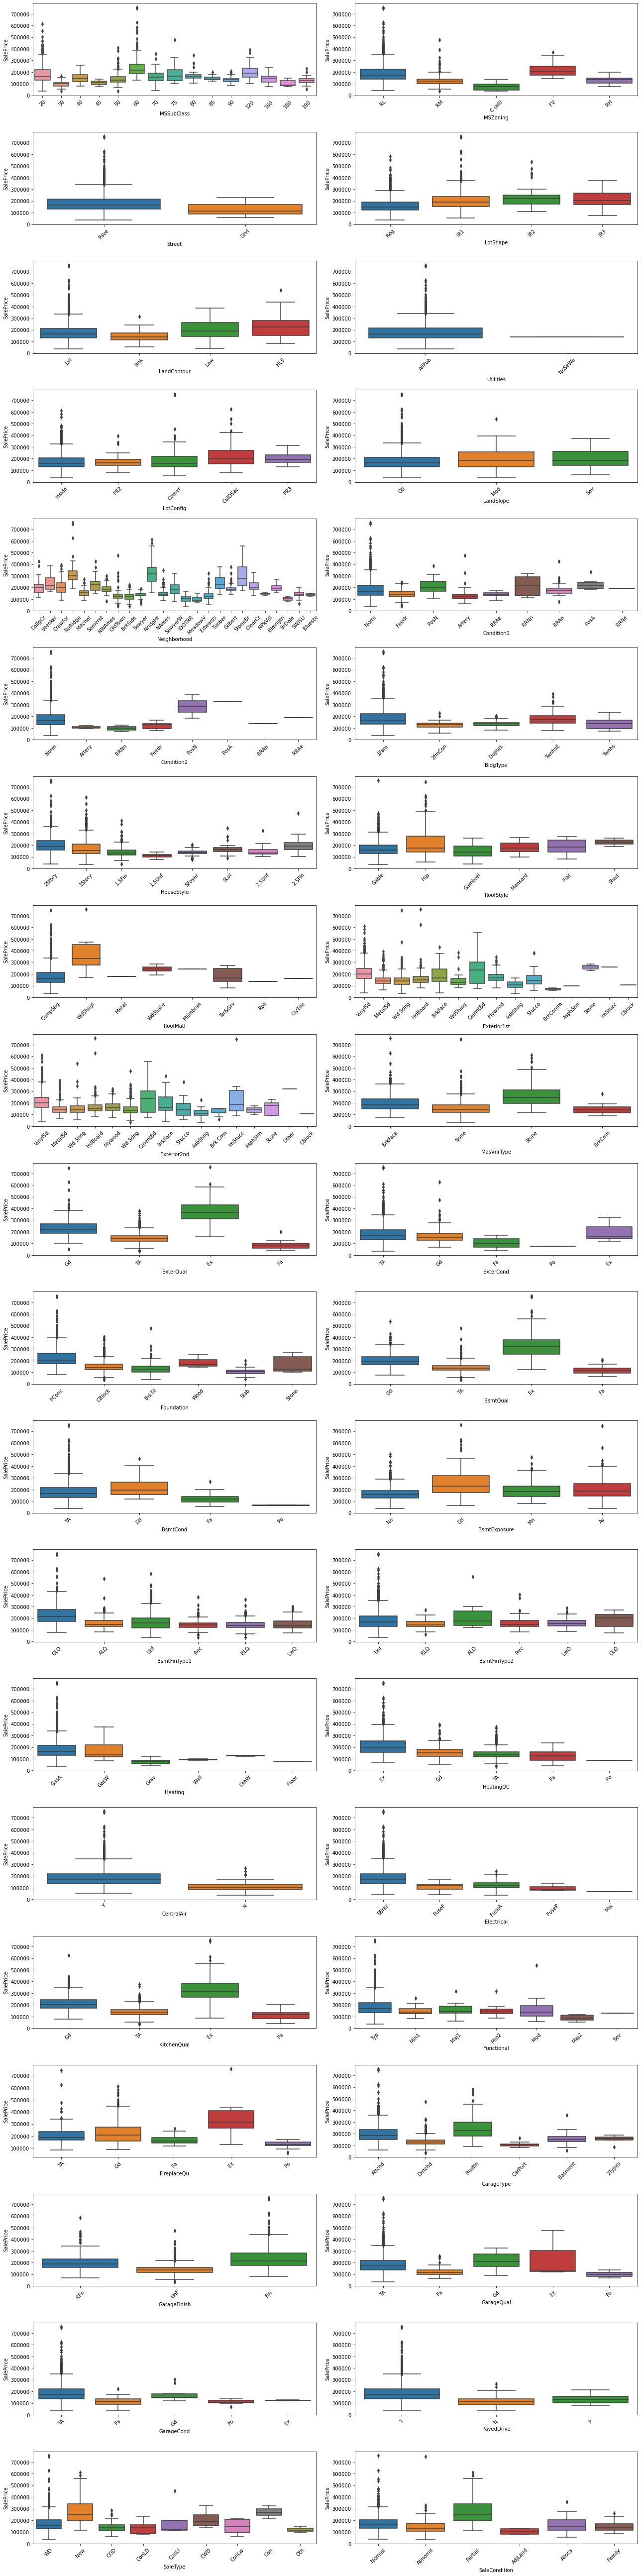

In [270]:
box_plots (df_train, categorical_vars)

In [267]:
def scatter_plots (df, cont_vars):
    '''Plot to review relationship between independent continious variables and target'''
    cont_vars_copy = cont_vars.copy() # CDrop the Id variable from the list
    cont_vars_copy.remove ('Id')
    f = plt.figure(figsize=(14,24))
    for count, value in enumerate(cont_vars_copy):
        f.add_subplot(10, 4, count+1)
        sns.scatterplot(x=df[value], y='SalePrice', data=df.drop(columns='Id', axis=1))
    plt.tight_layout()
    plt.show()

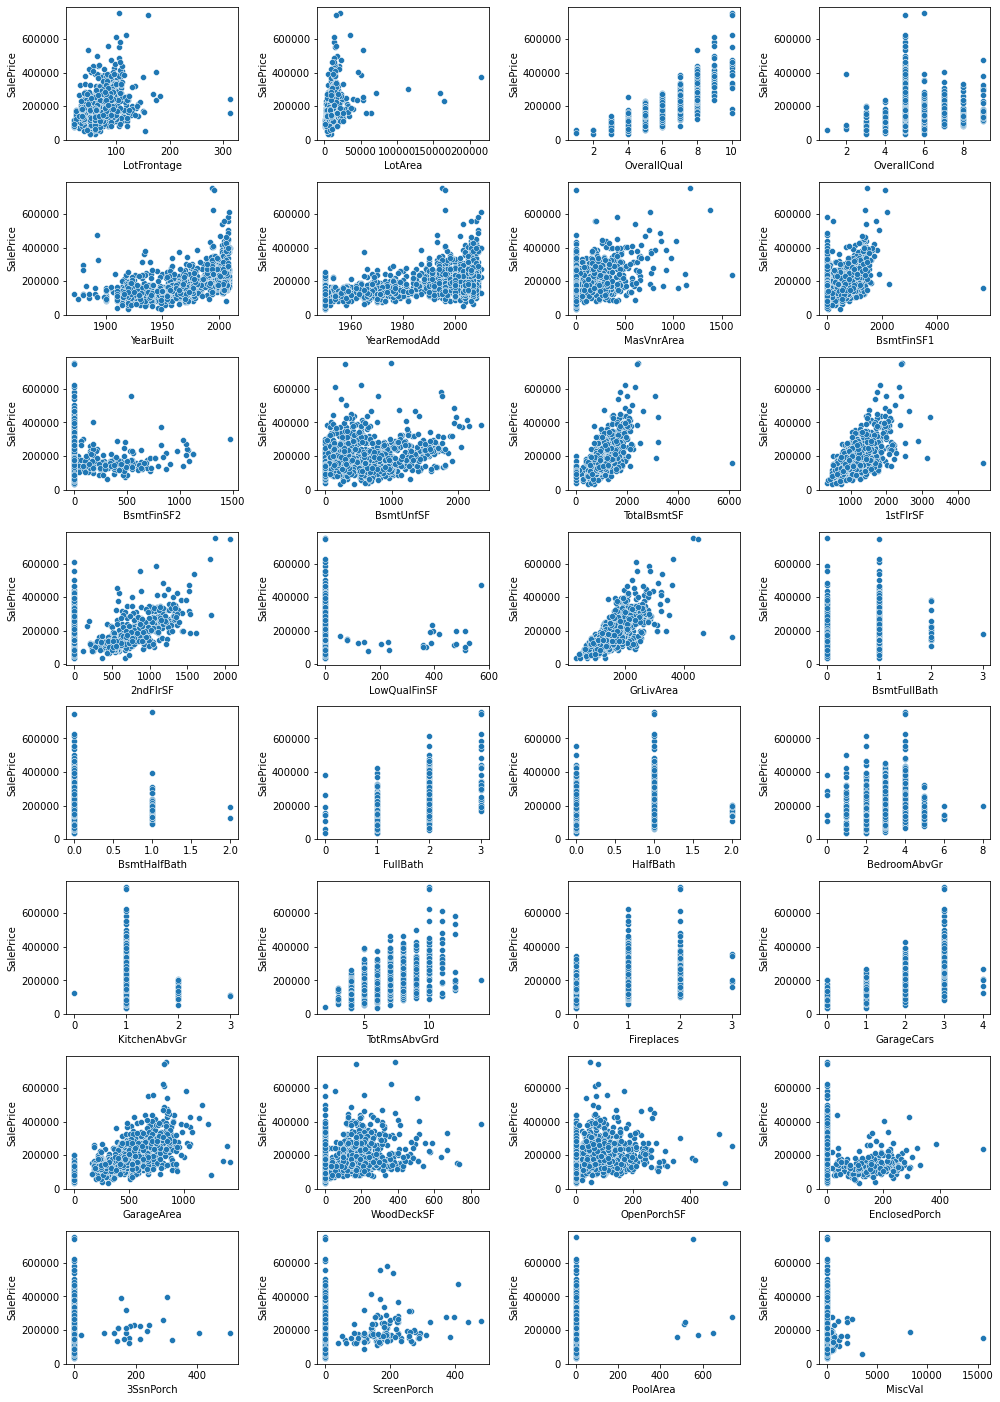

In [268]:
scatter_plots(df_train, numerical_vars)

In [274]:
def cor_heat_map (df):
    # Correlation Matrix Heatmap
    f, ax = plt.subplots(figsize=(20, 16))
    corr = type_converted_df[categorical_vars + numerical_vars + ['SalePrice']].drop('Id', axis=1).corr()
    hm = sns.heatmap(round(corr,2), annot=True, ax=ax, cmap="coolwarm",fmt='.2f',linewidths=.05)
    f.subplots_adjust(top=0.95)
    t= f.suptitle('House Pricing Dataset Correlation Heatmap', fontsize=16)

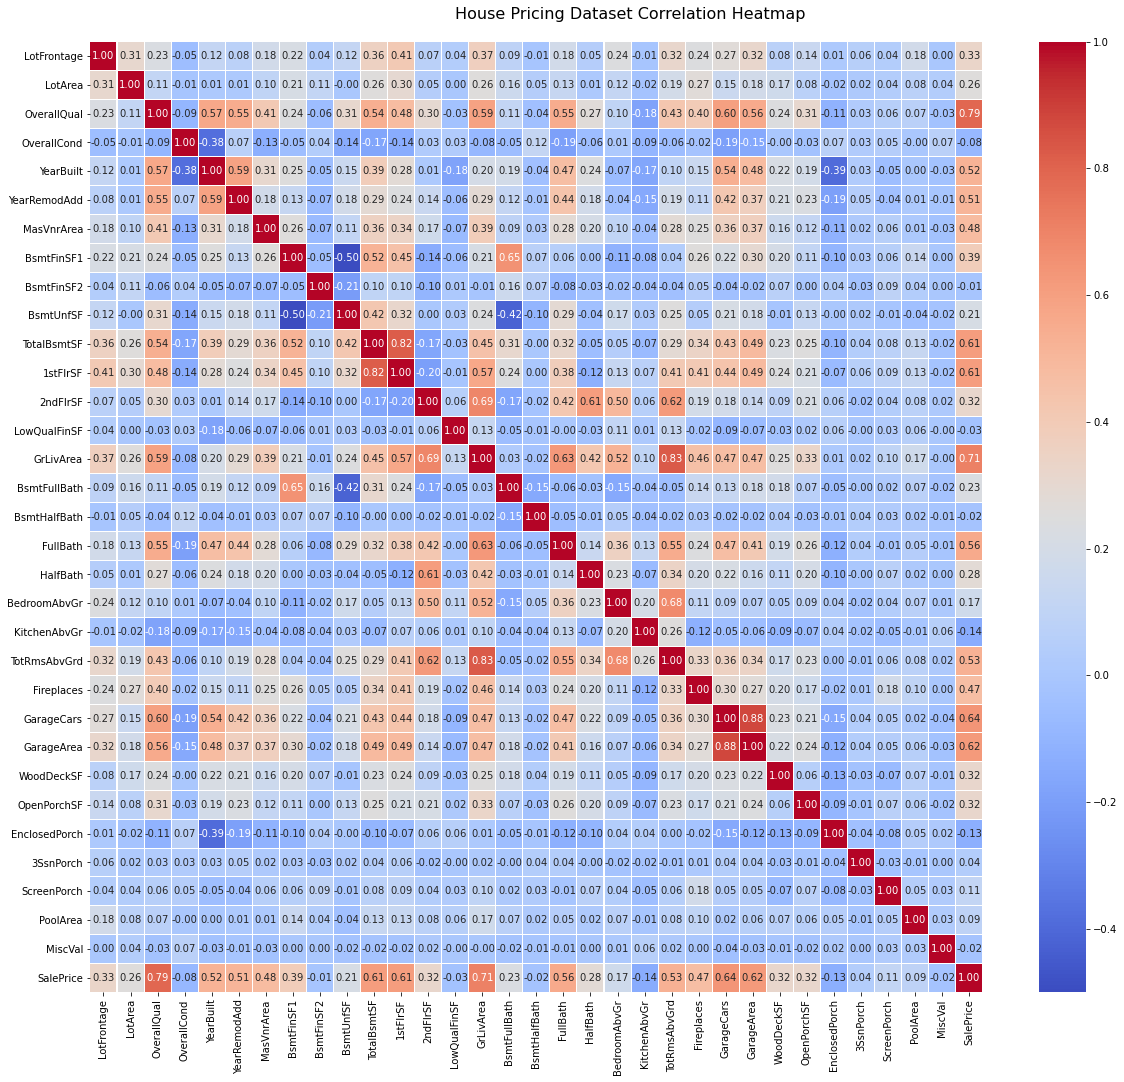

In [276]:
cor_heat_map(df_train)

#### There is a high correlation between SalePrice OverallQual, GrLivArea, medium correlation between SalePrice and GarageArea, GarageCars, TotRoomsAbvGrd,Firecplaces, YearBuilt.

### ---- 5 Establish a baseline ----

In [ ]:
#select a reasonable metric (MSE in this case)
#create an extremely simple model and measure its efficacy
#e.g. use "average salary" for each industry as your model and then measure MSE
#during 5-fold cross-validation

### ---- 6 Hypothesize solution ----

In [ ]:
#brainstorm 3 models that you think may improve results over the baseline model based
#on your 

Brainstorm 3 models that you think may improve results over the baseline model based on your EDA and explain why they're reasonable solutions here.

Also write down any new features that you think you should try adding to the model based on your EDA, e.g. interaction variables, summary statistics for each group, etc

## Part 3 - DEVELOP

You will cycle through creating features, tuning models, and training/validing models (steps 7-9) until you've reached your efficacy goal

#### Your metric will be MSE and your goal is:
 - <360 for entry-level data science roles
 - <320 for senior data science roles

### ---- 7 Engineer features  ----

In [ ]:
#make sure that data is ready for modeling
#create any new features needed to potentially enhance model

### ---- 8 Create models ----

In [ ]:
#create and tune the models that you brainstormed during part 2

### ---- 9 Test models ----

In [ ]:
#do 5-fold cross validation on models and measure MSE

### ---- 10 Select best model  ----

In [ ]:
#select the model with the lowest error as your "prodcuction" model

## Part 4 - DEPLOY

### ---- 11 Automate pipeline ----

In [ ]:
#write script that trains model on entire training set, saves model to disk,
#and scores the "test" dataset

### ---- 12 Deploy solution ----

In [ ]:
#save your prediction to a csv file or optionally save them as a table in a SQL database
#additionally, you want to save a visualization and summary of your prediction and feature importances
#these visualizations and summaries will be extremely useful to business stakeholders

### ---- 13 Measure efficacy ----

We'll skip this step since we don't have the outcomes for the test data